In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

In [2]:
# Load MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape Images to Match Model Input Shape (28x28x1)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Print Dataset Information
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


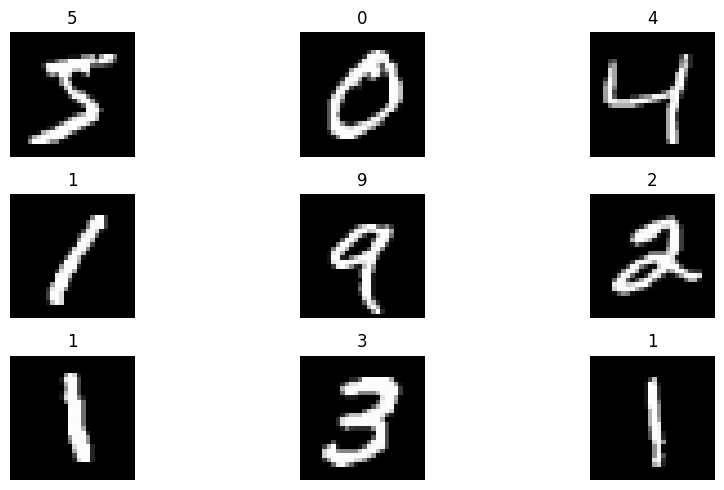

In [3]:
# Display Sample Images
fig, ax = plt.subplots(3, 3, figsize=(10, 5))
subset_index = np.arange(9)
subset_image = train_images[subset_index]
subset_label = train_labels[subset_index]
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        ax[i][j].imshow(subset_image[index].reshape(28, 28), cmap='gray')
        ax[i][j].set_title(subset_label[index])
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [4]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import numpy as np

# Shuffle the data before creating the ImageDataGenerator
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_images = train_images[indices]
train_labels = train_labels[indices]

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2  # Define validation split here
)
datagen.fit(train_images)

# Updated Model Definition
def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), input_shape=(28, 28, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        layers.AveragePooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        layers.AveragePooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        layers.AveragePooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        layers.Dropout(0.3),

        layers.Dense(10, activation='softmax')
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 5e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning_optimized'
)

tuner.search(datagen.flow(train_images, train_labels, batch_size=64, subset='training'),
             epochs=20,
             validation_data=datagen.flow(train_images, train_labels, batch_size=64, subset='validation'),
             callbacks=[early_stopping, reduce_lr])

# Retrieve Best Model and Evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)

print(f"Best Test Accuracy: {test_accuracy}")
print(f"Best Test Loss: {test_loss}")


Trial 3 Complete [00h 11m 33s]
val_accuracy: 0.987333357334137

Best val_accuracy So Far: 0.9917500019073486
Total elapsed time: 00h 32m 58s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9930 - loss: 0.0191
Best Test Accuracy: 0.9944999814033508
Best Test Loss: 0.01521144900470972


In [6]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img.thumbnail((20, 20))
    new_img = Image.new('L', (28, 28), 255)
    img_w, img_h = img.size
    offset = ((28 - img_w) // 2, (28 - img_h) // 2)
    new_img.paste(img, offset)
    img_array = np.array(new_img)
    img_array = 255 - img_array  # Invert the image
    img_array = img_array / 255.0  # Normalize
    img_array = img_array.reshape(1, 28, 28, 1)
    return img_array

In [7]:
def visualize_image(image_array):
    img_to_show = image_array.reshape(28, 28)
    plt.imshow(img_to_show, cmap='gray')
    plt.show()

# Predict the Digit
def predict_digit(preprocessed_image):
    prediction = best_model.predict(preprocessed_image)
    print(f'Prediction probabilities: {prediction}')
    predicted_digit = np.argmax(prediction)
    return predicted_digit

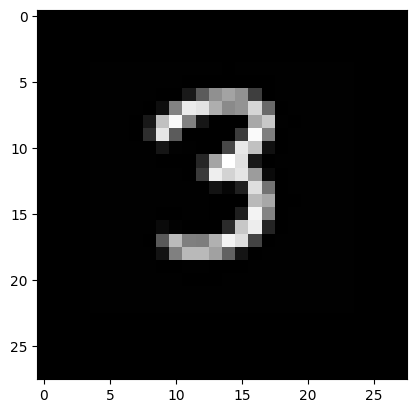

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Prediction probabilities: [[1.14085864e-07 2.68771164e-05 6.53945375e-04 9.98130977e-01
  4.79738048e-07 7.63848366e-05 3.67342530e-08 1.33024791e-04
  3.11324925e-06 9.75051487e-04]]
Predicted digit: 3


In [8]:
# Input Path of Image
image_path = r"digit3.jpeg"  # Update the path to your image

# Preprocess and Visualize the Image
preprocessed_image = preprocess_image(image_path)
visualize_image(preprocessed_image)

# Predict and Display the Result
predicted_digit = predict_digit(preprocessed_image)
print(f'Predicted digit: {predicted_digit}')

In [9]:
import numpy as np

# Predict the probabilities for the test set
predictions = best_model.predict(test_images)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Separate predictions for digits 7 and 8
seven_indices = np.where(test_labels == 7)[0]
eight_indices = np.where(test_labels == 8)[0]


seven_correct = np.sum(predicted_labels[seven_indices] == test_labels[seven_indices])
eight_correct = np.sum(predicted_labels[eight_indices] == test_labels[eight_indices])

seven_accuracy = seven_correct / len(seven_indices) if len(seven_indices) > 0 else 0
eight_accuracy = eight_correct / len(eight_indices) if len(eight_indices) > 0 else 0

print(f"Accuracy for digit 7: {seven_accuracy}")
print(f"Accuracy for digit 8: {eight_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for digit 7: 0.9961089494163424
Accuracy for digit 8: 0.9938398357289527


In [10]:
#Extracting summary metrics (e.g., accuracy, precision, recall, F1 score) table.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,Accuracy,0.994500
1,Precision,0.994508
2,Recall,0.994500
3,F1 Score,0.994499


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9911 - loss: 0.0282 - val_accuracy: 0.9943 - val_loss: 0.0214
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9921 - loss: 0.0254 - val_accuracy: 0.9948 - val_loss: 0.0188
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9938 - loss: 0.0203 - val_accuracy: 0.9941 - val_loss: 0.0229
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9912 - loss: 0.0268 - val_accuracy: 0.9942 - val_loss: 0.0218
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9917 - loss: 0.0267 - val_accuracy: 0.9953 - val_loss: 0.0153
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9932 - loss: 0.0220 - val_accuracy: 0.9959 - val_loss: 0.0163
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9931 - loss: 0.0218 - val_accuracy: 0.9945 - val_loss: 0.0227
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9941 - loss: 0.0207

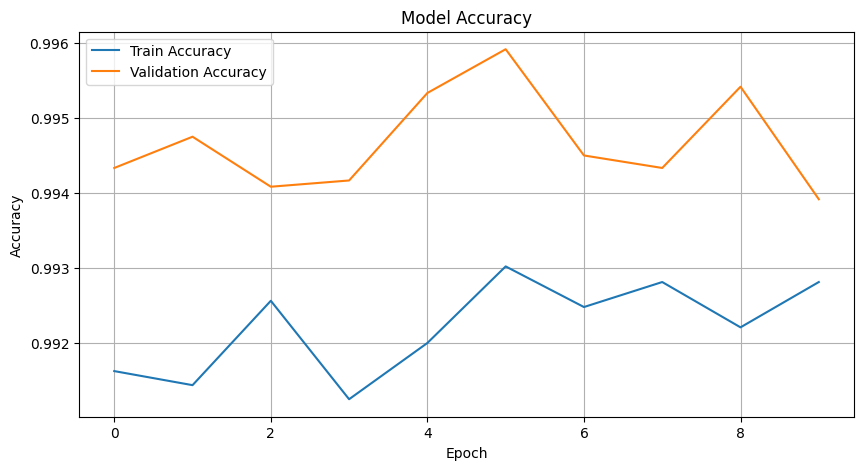

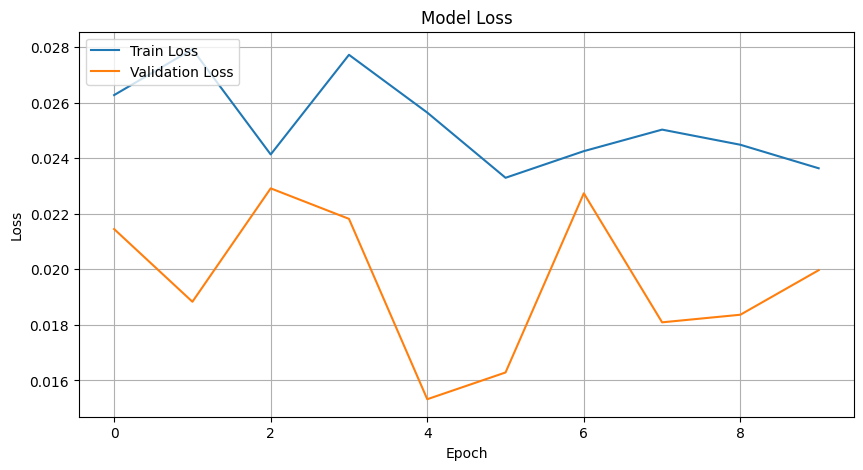

In [14]:
# Fit the model and capture the history
history = best_model.fit(train_images, train_labels, validation_split=0.2, epochs=10)

# Get the training history
history_data = history.history

# Plot training accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_data.get('accuracy', []), label='Train Accuracy')
plt.plot(history_data.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# Plot training loss values
plt.figure(figsize=(10, 5))
plt.plot(history_data.get('loss', []), label='Train Loss')
plt.plot(history_data.get('val_loss', []), label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

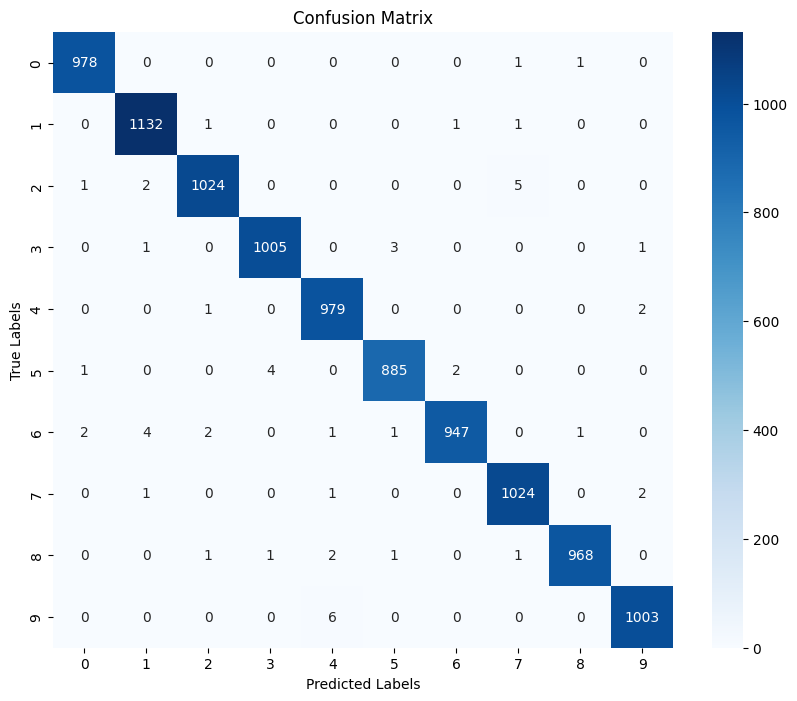

In [15]:
#Displaying the confusion matrix as a heatmap.

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()